# 0. Original author：Jose Portilla et al.

For complete notes and comments:

Udemy Course: Deep Learning with PyTorch for Medical Image Analysis

(https://www.udemy.com/course/deep-learning-with-pytorch-for-medical-image-analysis/)

# 数据集

Medical Segmentation Decathlon (http://medicaldecathlon.com/)

(Data License: https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
root = Path(r"H:\1. DL\Atrium Seg/Task02_Heart/imagesTr/")
label = Path(r"H:\1. DL\Atrium Seg/Task02_Heart/labelsTr/")

# 1. 看看原始数据

In [3]:
# 为了方便读取相应的label
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [4]:
sample_path = list(root.glob("la*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

p1=list(root.glob("la*"))
print(p1)

[WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_007.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_019.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_023.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_005.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_009.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_017.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_021.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_029.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_003.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_011.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_030.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_022.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_014.nii.gz'), WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_018.n

In [5]:
sample_path, sample_path_label

(WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/imagesTr/la_007.nii.gz'),
 WindowsPath('H:/1. DL/Atrium Seg/Task02_Heart/labelsTr/la_007.nii.gz'))

In [7]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)  # Class labels should not be handled as float64

# 查看orientation
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [8]:
from celluloid import Camera
from IPython.display import HTML

### Error: Requested MovieWriter (ffmpeg) not available: Easy Fix
参考：https://suryadayn.medium.com/error-requested-moviewriter-ffmpeg-not-available-easy-fix-9d1890a487d3

- `!pip install ffmpeg-python`

- Downloading the FFMpeg build for your Windows/Mac OS from the below link:

    https://ffmpeg.org/download.html

    ffmpeg-master-latest-win64-gpl.zip
    
    
- 把\bin的路径，配置到环境变量

### Jupyter Notebook 和绘图有关的几个魔术指令（%matplotlib inline, auto, notebook）
https://blog.csdn.net/qq_26822029/article/details/103064856

<IPython.core.display.Javascript object>


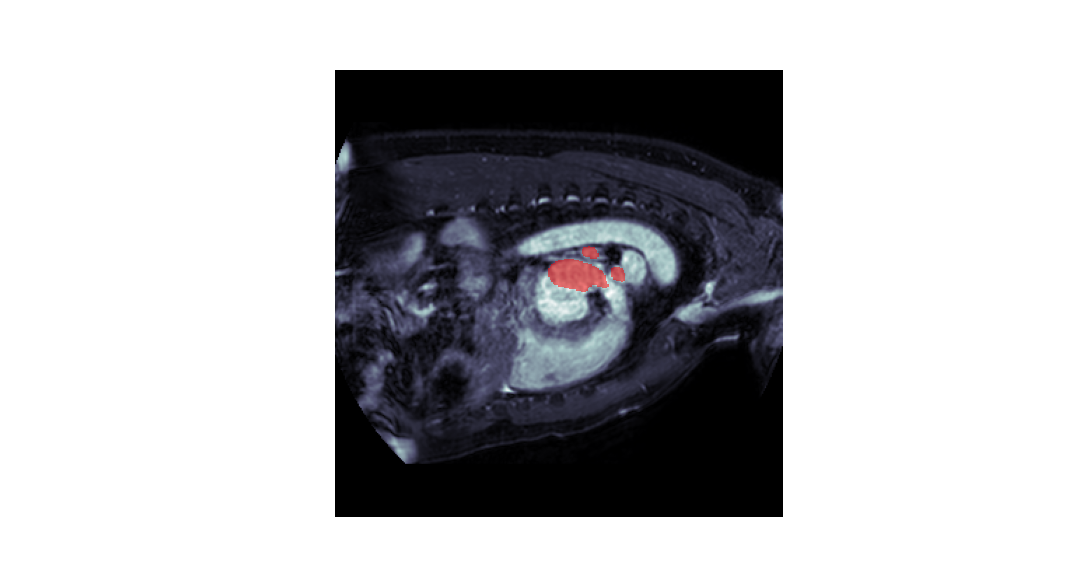

In [26]:
%matplotlib notebook
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i]) # 无效化/去掉背景（条件，操作的对象）
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.imshow(mask[:,:,i], alpha=0.5)
    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation


### 【numpy操作】掩码处理
https://blog.csdn.net/weixin_53063763/article/details/125533158?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522167558895716800182150931%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=167558895716800182150931&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-1-125533158-null-null.142^v73^control,201^v4^add_ask,239^v1^insert_chatgpt&utm_term=np.ma.masked_where&spm=1018.2226.3001.4187

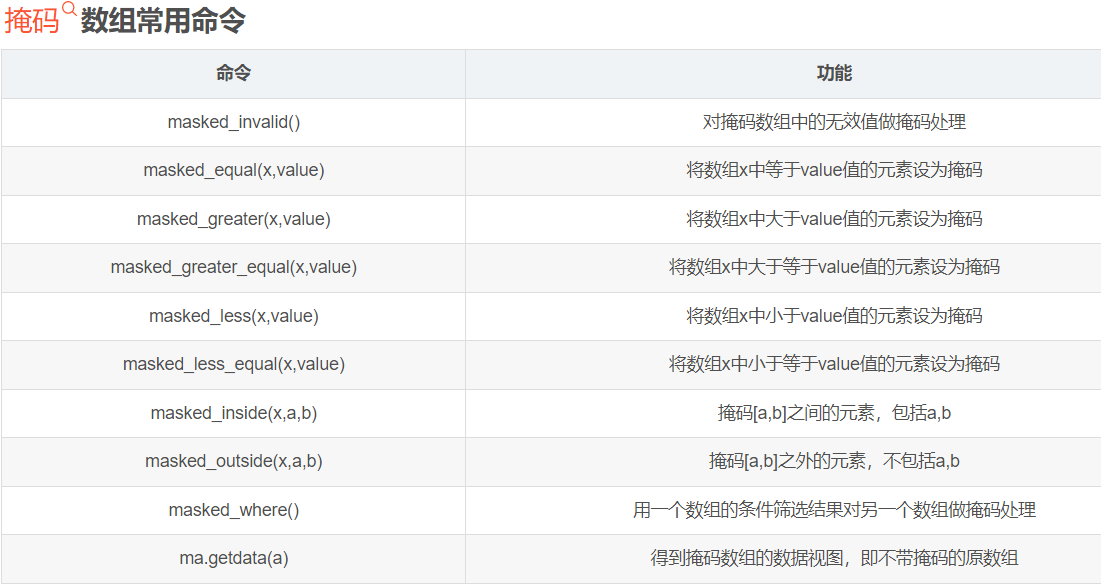

<IPython.core.display.Javascript object>


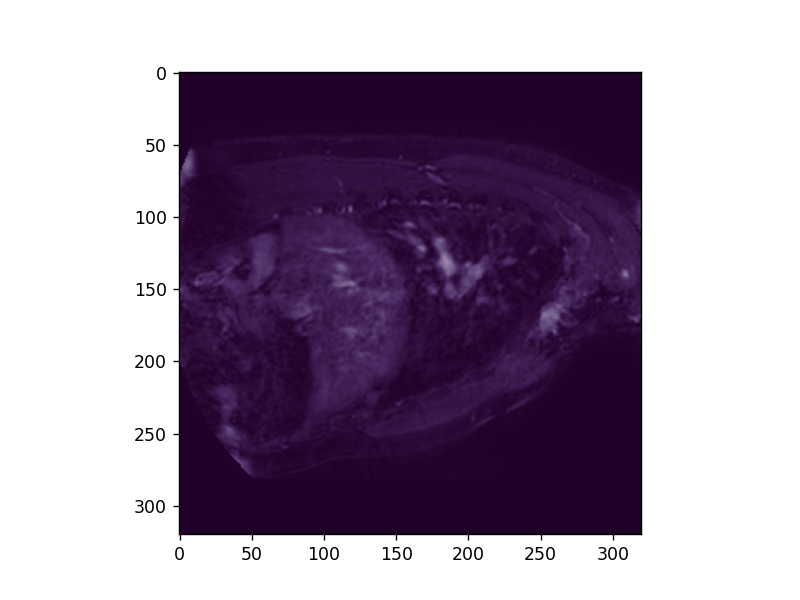

In [27]:
%matplotlib notebook
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i], cmap="bone")
    #mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i]) # 无效化/去掉背景（条件，操作的对象）
    #plt.imshow(mask_, alpha=0.5, cmap="autumn")
    
    plt.imshow(mask[:,:,i], alpha=0.5)

    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation




In [13]:
# %matplotlib notebook # 对to_html5_video()没用的
HTML(animation.to_html5_video())  # convert the animation to a video


## 2. Preprocessing
We perform the following preprocessing steps:

1. Normalization per subject. We compute mean and sigma of the full 3d volume $X$ and then perform z-normalization:
$$X_n = \frac{X-\mu}{\sigma}$$
2. There is a plenty of empty space around the image, so we can crop the image (e.g 32 px from top and bottom). Additionally, we can crop away non-cardiac regions as they will definitely not contain the left atrium. This will  reduce training time due to the smaller size and will simplify the segmentation. It is important to crop first and to normalize afterwards. Otherwise the included zero values introduce skewness to the intesity distribution.否则，包括零值会向强度分布引入偏度。就是说注意下顺序，先裁剪再normalize
3. Standardize the normalized subject into the 0-1 range:
$$X_s = \frac{X_n - min(X_n)}{max(X_n)-min(X_n)} $$
4. This task will be performed on a slice level (2D) and not on a subject level (3D). In order to reduce the computational cost we store the preprocessed data as npy files of 2d slices. Reading a single slice is much faster than loading the complete NIfTI file every time.

In [14]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


In [15]:
all_files = list(root.glob("la*"))  # Get all subjects
len(all_files)

20

In [28]:
save_root = Path(r"H:\1. DL\Atrium Seg/Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)): #tqdm to get the process bar
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    # write an assertion 确保方向都是这样排列的
    ## Python assert（断言）用于判断一个表达式，在表达式条件为 false 的时候触发异常。
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")    
    
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
    # Addtionally crop front and back with same size. Dont crop viewing axis
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    # Normalize and standardize the images
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    # 划分训练集和验证集
    # Check if train or val data and create corresponding path
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
    for i in range(standardized_mri_data.shape[-1]): #shape[-1]代表最后一个维度
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)# parents：如果父目录不存在，是否创建父目录。
        mask_path.mkdir(parents=True, exist_ok=True) # exist_ok：只有在目录不存在时创建目录，目录已存在时不会抛出异常。
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        
    

  0%|          | 0/20 [00:00<?, ?it/s]

### enumerate用法总结
https://blog.csdn.net/qq_32252917/article/details/78174835?ops_request_misc=&request_id=&biz_id=102&utm_term=%20enumerate(list)%E7%94%A8%E6%B3%95&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-0-78174835.142^v73^wechat,201^v4^add_ask,239^v1^control&spm=1018.2226.3001.4187

enumerate()是python的内置函数 enumerate在字典上是枚举、列举的意思 对于一个可迭代的（iterable）/可遍历的对象（如列表、字符串），enumerate将其组成一个索引序列，利用它可以同时获得索引和值 enumerate多用于在for循环中得到计数 例如对于一个seq，得到： (0, seq[0]), (1, seq[1]), (2, seq[2])

In [16]:
tqdm(all_files)

  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    print(counter,path_to_mri_data)

  0%|          | 0/20 [00:00<?, ?it/s]

0 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_007.nii.gz
1 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_019.nii.gz
2 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_023.nii.gz
3 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_005.nii.gz
4 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_009.nii.gz
5 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_017.nii.gz
6 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_021.nii.gz
7 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_029.nii.gz
8 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_003.nii.gz
9 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_011.nii.gz
10 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_030.nii.gz
11 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_022.nii.gz
12 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_014.nii.gz
13 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_018.nii.gz
14 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_020.nii.gz
15 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_004.nii.gz
16 H:\1. DL\Atrium Seg\Task02_Heart\imagesTr\la_016.nii.gz
17 H:\1

### assert
Python3 assert（断言）
https://www.runoob.com/python3/python3-assert.html

python assert函数解析
https://blog.csdn.net/TeFuirnever/article/details/88883859

### 切片 X[s0:e0,s1:e1]
这是最通用的切片操作，表示取 第0维 的第 s0 到 e0 个元素，继续取 第1维 的第 s1 到 e1 个元素（左闭右开）。如 X[1:3,1:3] 表示第0维第(1:3)个元素[[10,11,12,13],[20,21,22,23]],然后取其第1维的第(1:3)个元素即 [[11,12],[21,22]]；


Python中numpy数组切片：print(a[0::2])、a[::2]、[:,2]、[1:,-1:]、a[::-1]、[ : n]、[m : ]、[-1]、[:-1]、[1:]等的含义（详细）
https://blog.csdn.net/weixin_43629813/article/details/101122997?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522167559350316782425159434%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=167559350316782425159434&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-9-101122997-null-null.142^v73^wechat,201^v4^add_ask,239^v1^control&utm_term=python%E6%95%B0%E7%BB%84%E3%80%9032%3A-32%E3%80%91&spm=1018.2226.3001.4187


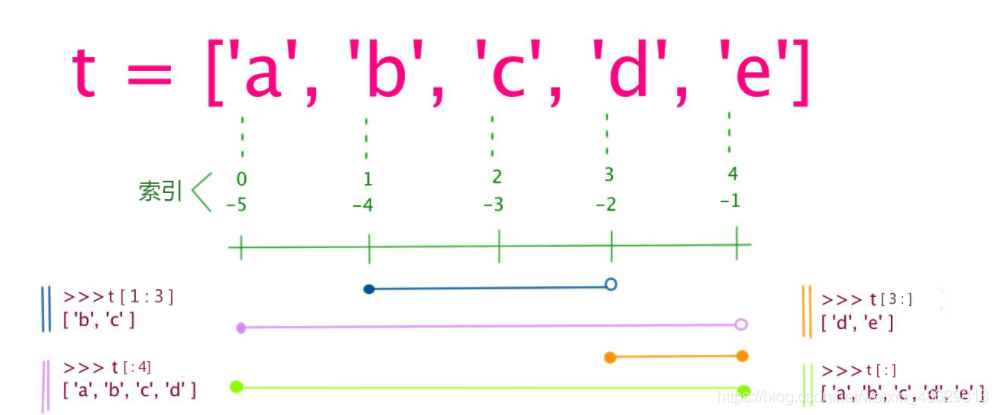

In [18]:
# Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
# Addtionally crop front and back with same size. Dont crop viewing axis
mri1 = mri[32:-32, 32:-32]

# 320-32-32 = 256

In [19]:
# show all data
np.set_printoptions(threshold=np.inf)

In [20]:
print(mri1[:,:,0])

[[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.

<IPython.core.display.Javascript object>


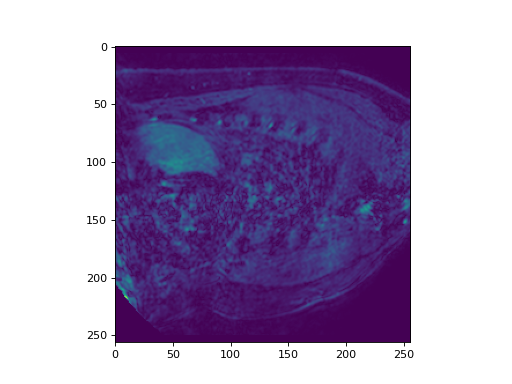

In [21]:
plt.imshow(mri1[:,:,0])

In [22]:
mri1.shape

(256, 256, 130)

In [23]:
mri1.dtype

dtype('float64')

In [24]:
mask.shape

(320, 320, 130)

In [25]:
mask.dtype

dtype('uint8')

## 3. Validate preprocessed data
Now, we can take a look at the stored files and inspect if everything works

In [29]:
path = Path(r"H:\1. DL\Atrium Seg/Preprocessed/train/1/")  # Select a subject

# Choose a file and load slice + mask
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


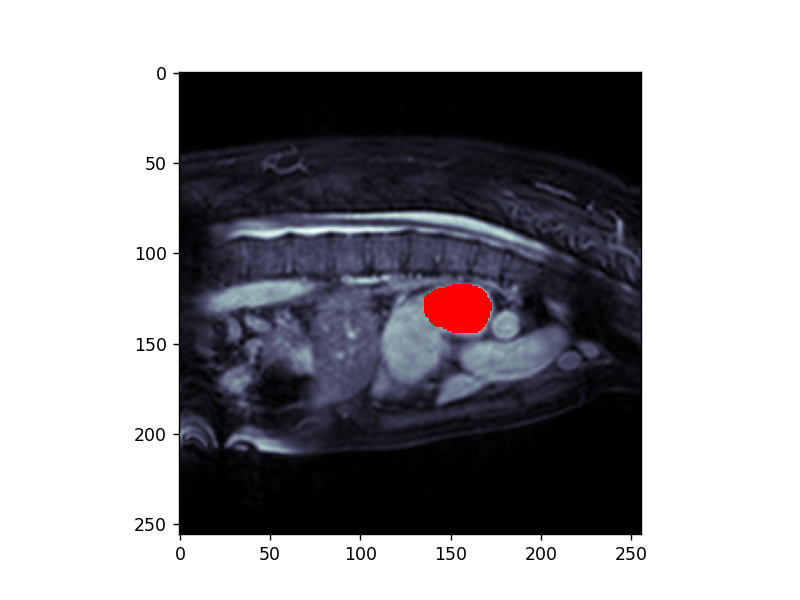

In [30]:
# Plot everything
plt.figure()
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, cmap="autumn")

In [31]:
print(slice.min(), slice.max())

0.0 0.9855595667870035
